# [실습 5] Agentic RAG

학습 내용:
Agentic RAG는 기존 RAG를 기반으로, 동적으로 작업을 실행할 수 있는 자율적인 의사 결정 주체인 Agent를 도입한 것으로  
쿼리에 따라 필요한 도구를 불러서 사용할 수 있습니다.  
지금까지 만든 도구들을 가지고 하나의 Agent로 구축해보겠습니다.  


## 1. 환경 설정 및 기본 세팅
필요한 라이브러리들을 설치하고 import 합니다.  

In [ ]:
import os

from langchain import hub
from langchain.agents import AgentExecutor, create_openai_functions_agent, tool
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import PyPDFLoader, WebBaseLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

USER_AGENT environment variable not set, consider setting it to identify your requests.


OpenAI API 키를 환경변수로 설정하여 GPT 모델을 사용할 수 있도록 준비합니다.

In [2]:
import os

from dotenv import load_dotenv

# .env 파일 로드, 환경 변수에서 API 키 읽기
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# 도구 내부에서 사용할 LLM (요약, 번역 등)
llm_for_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0)
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

## 2. RAG 파이프라인 구축 (문서 로드, 분할, 임베딩, 벡터 스토어 생성)
Agent가 특정 전문 분야에 대해 깊이 있는 답변을 하려면, 해당 분야의 지식을 검색할 수 있는 내부 데이터베이스가 필요합니다.   
이 단계는 "Attention Is All You Need" 논문 PDF를 Agent가 참고할 수 있는 '지식 창고(Vector Store)'로 만드는 과정입니다.

1.  **데이터 로드 (Loading):**
    *   `PyPDFLoader`를 사용하여 웹에 있는 논문 PDF 파일을 불러옵니다. 이 단계는 Agent에게 학습시킬 원본 지식 데이터를 가져오는 첫걸음입니다.

2.  **텍스트 분할 (Splitting):**
    *   로드한 문서는 양이 방대하므로, LLM이 한 번에 처리할 수 있는 의미 있는 작은 단위, 즉 '청크(Chunk)'로 나눕니다.
    *   `RecursiveCharacterTextSplitter`는 문단의 의미가 최대한 유지되도록 문단, 문장 순으로 자릅니다. `chunk_overlap` 옵션은 청크 간의 내용이 일부 겹치게 하여, 분할 지점에서 문맥이 끊기는 것을 방지합니다.

3.  **임베딩 (Embedding):**
    *   분할된 텍스트 청크들을 컴퓨터가 이해할 수 있는 숫자 벡터(Vector)로 변환합니다.
    *   임베딩 모델을 사용하여 각 청크의 '의미'를 벡터 공간의 특정 좌표로 맵핑합니다. **의미가 비슷한 텍스트는 벡터 공간에서도 가까운 위치에 존재하게 됩니다.**

4.  **벡터 스토어 구축 및 검색기 생성 (Storing & Retrieving):**
    *   변환된 모든 벡터들을 `FAISS`라는 고속 벡터 데이터베이스에 저장하고 인덱싱합니다. 이제 이 벡터 스토어는 우리의 '지식 창고' 역할을 합니다.
    *   마지막으로, 이 벡터 스토어에서 정보를 쉽게 꺼내 쓸 수 있도록 `as_retriever()`를 통해 '검색기(Retriever)'를 생성합니다. 이 검색기는 질문이 들어오면 질문의 의미 벡터와 가장 가까운 벡터(즉, 가장 관련성 높은 문서 청크)를 신속하게 찾아주는 역할을 합니다.

> **요약:** 원본 PDF 문서를 잘게 나누고, 각 조각의 의미를 숫자로 변환하여 검색이 용이한 데이터베이스에 저장함으로써, Agent가 특정 주제에 대해 빠르게 참조할 수 있는 **개인화된 검색 엔진**을 만든 것입니다.


In [4]:
# 1. 데이터 로드 (PDF)
pdf_url = "UnderstandingDeepLearning_05_29_25_C.pdf"
loader = PyPDFLoader(pdf_url)
docs = loader.load()
print(f"- '{docs[0].metadata['source']}' 에서 {len(docs)}개 페이지 로드 완료")


# 2. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
split_docs = text_splitter.split_documents(docs)
print(f"- {len(docs)}개 페이지를 {len(split_docs)}개의 청크로 분할 완료")


# 3. 벡터 스토어 생성 및 검색기(Retriever) 설정
# split_docs를 4등분하여 FAISS에 순차적으로 추가
chunk_size = len(split_docs) // 4
print(f"- 총 {len(split_docs)}개 청크를 4등분하여 순차적으로 벡터 스토어에 추가")

# 첫 번째 1/4로 벡터 스토어 초기화
first_chunk = split_docs[:chunk_size]
vectorstore = FAISS.from_documents(first_chunk, embedding_model)
print(f"- 1/4 청크 ({len(first_chunk)}개) 초기 벡터 스토어 생성 완료")

# 나머지 3/4을 순차적으로 추가
for i in range(1, 4):
    start_idx = i * chunk_size
    end_idx = start_idx + chunk_size if i < 3 else len(split_docs)  # 마지막 청크는 나머지 모든 문서
    chunk_docs = split_docs[start_idx:end_idx]

    if chunk_docs:  # 빈 청크가 아닌 경우에만 추가
        vectorstore.add_documents(chunk_docs)
        print(f"- {i+1}/4 청크 ({len(chunk_docs)}개) 벡터 스토어에 추가 완료")

retriever = vectorstore.as_retriever()
print("- FAISS 벡터 스토어 및 검색기 생성 완료")
print("RAG 파이프라인 구축 완료")
print("=" * 50)

- 'UnderstandingDeepLearning_05_29_25_C.pdf' 에서 541개 페이지 로드 완료
- 541개 페이지를 955개의 청크로 분할 완료
- 총 955개 청크를 4등분하여 순차적으로 벡터 스토어에 추가
- 1/4 청크 (238개) 초기 벡터 스토어 생성 완료
- 2/4 청크 (238개) 벡터 스토어에 추가 완료
- 3/4 청크 (238개) 벡터 스토어에 추가 완료
- 4/4 청크 (241개) 벡터 스토어에 추가 완료
- FAISS 벡터 스토어 및 검색기 생성 완료
RAG 파이프라인 구축 완료


## 3. 다중 도구(Tools) 생성
Agent는 스스로 웹 검색을 하거나 번역을 할 수 없습니다.   
이러한 기능들은 '도구(Tool)'의 형태로 만들어서 Agent에게 제공해야 합니다.   
이 단계에서는 Agent가 사용할 수 있는 4가지 핵심 능력을 정의하고 구현합니다.

**핵심 원리:**
각 도구에는 **이름(`name`)** 과 **설명(`description`)** 이 있습니다.   
Agent의 두뇌 역할을 하는 LLM은 사용자의 질문을 보고, 각 도구의 '설명'을 읽은 뒤, 어떤 도구를 사용하는 것이 가장 적절할지 판단합니다.    
**따라서 이 설명을 명확하고 상세하게 작성하는 것이 매우 중요합니다.**

*   **[도구 1] RAG 검색 도구 (`retriever_tool`):**
    *   위 `2단계`에서 만든 'Understanding Deep Learning' 책 전용 검색 엔진을 사용합니다.
    *   `create_retriever_tool` 함수를 통해 검색기(`retriever`)를 Agent가 사용할 수 있는 표준 도구 형태로 감쌉니다.
    *   Agent는 이 도구의 설명을 보고, 논문과 관련된 질문이 들어왔을 때 이 도구를 호출합니다.

*   **[도구 2] 웹 검색 도구 (`tavily_tool`):**
    *   실시간 인터넷 정보를 검색합니다.
    *   `TavilySearch`를 초기화하여 웹 검색 기능을 도구로 만듭니다.
    *   Agent는 최신 정보, 일반 상식 등 논문에 없는 내용을 질문받았을 때 이 도구를 선택합니다.

*   **[도구 3] 웹페이지 분석/요약 도구 (`process_and_summarize_webpage`):**
    *  사용자가 제공한 URL의 내용을 실시간으로 가져와 요약합니다.
    *  `@tool` 데코레이터를 사용하여 직접 만든 Python 함수를 Agent용 도구로 변환합니다.   
    * 이 함수는 URL을 입력받아 `WebBaseLoader`로 페이지 내용을 읽고, `load_summarize_chain`을 통해 LLM으로 내용을 요약하여 반환합니다.

*   **[도구 4] 번역 도구 (`translate_text`):**
    *  텍스트를 지정된 언어로 번역합니다.
    *  이 역시 `@tool` 데코레이터를 사용한 커스텀 함수입니다. 번역할 텍스트와 목표 언어를 입력받아, 번역 프롬프트와 LLM을 결합하여 번역 결과를 생성합니다.

In [5]:
# --- 도구 1: RAG 검색 도구 ---
retriever_tool = create_retriever_tool(
    retriever,
    "DeepLearningSearch",
    "머신러닝에 관련된 질문을 검색하고 반환합니다. 머신러닝이나 딥러닝에 관련된 질문에 사용해야 합니다. 최신 딥러닝 논문에 대한 내용은 포함되지 않을 수도 있습니다.",
)

# --- 도구 2: 웹 검색 도구 ---
tavily_tool = TavilySearchResults(
    max_results=5,
    description="최신 정보나 일반적인 사실에 대한 질문에 답하기 위해 웹을 검색합니다. 벡터 스토어에 없는 내용에 사용됩니다.",
)


# --- 도구 3: 웹페이지 분석/요약 도구 ---
@tool
def process_and_summarize_webpage(url: str):
    """
    사용자가 제공한 URL의 웹페이지 콘텐츠를 로드하여 분석하고 그 내용을 요약합니다.
    URL과 관련된 질문에 답하거나 내용을 요약해야 할 때 사용해야 합니다.
    """
    try:
        loader = WebBaseLoader([url])
        docs = loader.load()
        summarize_chain = load_summarize_chain(llm=llm_for_tools, chain_type="stuff")
        summary = summarize_chain.invoke(docs)  # run 대신 invoke 사용 (LangChain v0.2+)
        return summary
    except Exception as e:
        return f"오류가 발생했습니다: {e}"


# --- 도구 4: 번역 도구 ---
@tool
def translate_text(text: str, target_language: str):
    """
    주어진 텍스트를 지정된 대상 언어로 번역합니다.
    사용자가 번역을 요청할 때 사용해야 합니다.
    """
    prompt = ChatPromptTemplate.from_template("Translate the following text to {target_language}:\n\n{text}")
    translation_chain = prompt | llm_for_tools | StrOutputParser()
    return translation_chain.invoke({"text": text, "target_language": target_language})


print("=" * 50)

/tmp/ipykernel_13467/3707183963.py:9: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(


## 4. Agent 생성 및 연동
이제 준비된 '지식 창고'와 '도구들'을 사용하여 실제 작업을 수행할 Agent를 조립하고 실행 가능한 형태로 만드는 마지막 단계입니다.

1.  **도구 목록 통합 (Tool Integration):**
    *   앞서 만든 4개의 도구(`retriever_tool`, `tavily_tool` 등)를 하나의 Python 리스트(`tools`)에 담습니다. 이 리스트가 Agent에게 전달될 '공구함'입니다.

2.  **Agent의 두뇌(LLM) 선택 (LLM for Reasoning):**
    *   `ChatOpenAI` 모델을 `agent_llm`으로 초기화합니다. 이 LLM은 사용자의 질문에 직접 답하는 것이 아니라, **사용자의 질문 의도를 파악하고, 어떤 도구를 사용할지 '생각'하고 '결정'하는 추론(Reasoning)의 역할**을 담당합니다.

3.  **Agent 프롬프트 설정 (Prompting):**
    *   `hub.pull("hwchase17/openai-functions-agent")`를 통해 검증된 Agent용 프롬프트를 가져옵니다. 이 프롬프트는 Agent의 두뇌(LLM)에게 "너는 이제부터 보조원(Assistant)이야. 주어진 질문을 보고, 내가 준 도구 목록 중에서 가장 적합한 것을 골라 사용해. 그리고 그 결과를 바탕으로 최종 답변을 만들어." 와 같은 행동 지침을 제공합니다.

4.  **Agent 생성 (Agent Creation):**
    *   `create_openai_functions_agent` 함수에 **`두뇌(agent_llm)`**, **`공구함(tools)`**, **`행동 지침(prompt)`** 을 모두 전달하여 `agent`를 생성합니다. 이로써 논리적인 'Agent'가 완성됩니다.

5.  **Agent 실행기 생성 (Executor Creation):**
    *   마지막으로, 생성된 `agent`를 `AgentExecutor`로 감싸줍니다. `AgentExecutor`는 실제 실행을 담당하는 컨트롤러입니다.
    *   **작동 방식:**
        1.  사용자 질문을 `agent`에게 전달
        2.  `agent`(LLM)가 생각 후 사용할 도구와 입력값 결정 (예: "tavily_tool을 '최신 프론트엔드 프레임워크'라는 검색어로 호출해라")
        3.  `Executor`가 실제로 해당 도구를 실행하고 결과(검색 결과)를 얻음
        4.  결과를 다시 `agent`에게 전달
        5.  `agent`가 결과를 보고 최종 답변을 생성하거나, 필요시 다른 도구를 추가로 호출
        6.  이 과정이 반복되다 최종 답변이 완성되면 사용자에게 반환됩니다. `verbose=True`는 이 모든 중간 과정을 눈으로 볼 수 있게 해줍니다.

In [6]:
# 1. 사용할 도구 목록 통합
tools = [retriever_tool, tavily_tool]

# 2. Agent가 추론에 사용할 LLM
agent_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# 3. Agent 프롬프트 가져오기
prompt = hub.pull("hwchase17/openai-functions-agent")

# 4. Agent 생성
agent = create_openai_functions_agent(llm=agent_llm, prompt=prompt, tools=tools)

# 5. Agent 실행기(Executor) 생성
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

print("Agent 생성 및 연동 완료")
print("=" * 50)

Agent 생성 및 연동 완료


## 5. 통합 테스트

In [7]:
# --- 예시 1: RAG 검색 ---
print("\n--- [Test 1] 논문 관련 질문 ---")
question1 = "'Attention Is All You Need' 논문에서 제안하는 트랜스포머 모델의 주요 구성 요소는 무엇인가요?"
response1 = agent_executor.invoke({"input": question1})
print("\n[최종 답변]:", response1["output"])

# --- 예시 2: 웹 검색 ---
print("\n--- [Test 2] 일반 상식 질문 ---")
question2 = "요즘 가장 인기 있는 프론트엔드 프레임워크는 무엇인가요?"
response2 = agent_executor.invoke({"input": question2})
print("\n[최종 답변]:", response2["output"])

# --- 예시 3: 웹페이지 요약 ---
print("\n--- [Test 3] 웹페이지 요약 질문 ---")
question3 = "https://www.zdnet.co.kr/view/?no=20240117100149 이 뉴스 기사의 내용을 세 문장으로 요약해줘."
response3 = agent_executor.invoke({"input": question3})
print("\n[최종 답변]:", response3["output"])

# --- 예시 4: 번역 ---
print("\n--- [Test 4] 번역 질문 ---")
question4 = "'Transformer 모델은 순환 신경망의 필요성을 완전히 제거했습니다.' 이 문장을 영어로 번역해줘."
response4 = agent_executor.invoke({"input": question4})
print("\n[최종 답변]:", response4["output"])

# --- 예시 5: 복합 질문 (웹 검색) ---
print("\n--- [Test 5] 복합 질문 ---")
question5 = "대표적인 Object detection 모델을 소개해주고, 그 모델의 깃허브 주소를 알려줘"
response5 = agent_executor.invoke({"input": question5})
print("\n[최종 답변]:", response5["output"])


--- [Test 1] 논문 관련 질문 ---


> Entering new AgentExecutor chain...

Invoking: `DeepLearningSearch` with `{'query': 'Attention Is All You Need Transformer model components'}`


236 12
T ransformers
p
endence of the attention matrix on the inputs entirely and either used predetermined random
values or learned values. This performed surprisingly well across a variety of tasks.
Multi-head self-attention also has close connections to graph neural networks (see chapter 13),
convolution (Cordonnier et al., 2020), recurrent neural networks (Choromanski et al., 2020),
and memory retrieval in Hopfield networks (Ramsauer et al., 2021). F or more information on
the relationships between transformers and other models, consult Prince (2021a).
Positional encoding: The original transformer paper (V aswani et al., 2017) experimented
with predefining the positional encoding matrix Π, and learning the positional encoding Π.
It might seem odd to add the positional encodings to the D×N data matrix X rather

## 6. 조건부 분기 라우팅

조건부 분기 라우팅(Conditional Routing)은 LangGraph에서 입력에 따라 다른 경로로 워크플로우를 분기시키는 핵심 기능입니다.

### 주요 개념:
1. 조건부 엣지(Conditional Edges): `add_conditional_edges()` 메서드를 사용하여 특정 조건에 따라 다음 노드를 결정
2. 라우터(Router) 함수: 현재 상태를 분석하여 다음에 실행할 노드를 반환하는 함수
3. 엣지 매핑: 라우터 함수의 반환값을 실제 노드 이름에 매핑하는 딕셔너리

### 기본 구조:
```python
# 라우터 함수 정의
def router_function(state):
    # 상태를 분석하여 다음 노드 결정
    if condition1:
        return "node_a"
    elif condition2:
        return "node_b"
    else:
        return "end"

# 그래프에 조건부 엣지 추가
graph.add_conditional_edges(
    "current_node",           # 시작 노드
    router_function,          # 라우터 함수
    {                        # 엣지 매핑
        "node_a": "actual_node_a",
        "node_b": "actual_node_b", 
        "end": END
    }
)
```


In [8]:
# 질문 유형별 라우팅 시스템:

from typing import TypedDict

from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, StateGraph


# 상태 정의
class SimpleState(TypedDict):
    question: str
    question_type: str
    answer: str

In [9]:
# 각 전문 처리 노드들


def handle_translation(state: SimpleState):
    return {"answer": f"번역 전문 시스템이 '{state['question']}'을 처리했습니다."}


def handle_math(state: SimpleState):
    return {"answer": f"수학 계산 시스템이 '{state['question']}'을 처리했습니다."}


def handle_general(state: SimpleState):
    return {"answer": f"일반 질의응답 시스템이 '{state['question']}'을 처리했습니다."}

In [10]:
# 질문 분류 노드


def classify_question(state: SimpleState):
    question = state["question"].lower()

    if "번역" in question or "translate" in question:
        question_type = "translation"
    elif "계산" in question or "수학" in question:
        question_type = "math"
    else:
        question_type = "general"

    return {"question_type": question_type}


# 라우터 함수 - 질문 유형에 따라 분기
def route_question(state: SimpleState):
    question_type = state["question_type"]

    if question_type == "translation":
        return "translation"
    elif question_type == "math":
        return "math"
    else:
        return "general"


# 그래프 구성
workflow = StateGraph(SimpleState)

# 노드 추가
workflow.add_node("classifier", classify_question)
workflow.add_node("translation_handler", handle_translation)
workflow.add_node("math_handler", handle_math)
workflow.add_node("general_handler", handle_general)

# 엣지 연결
workflow.add_edge(START, "classifier")

# 조건부 엣지 추가 - 핵심 부분!
workflow.add_conditional_edges(
    "classifier",  # 분류기에서
    route_question,  # 라우터 함수로 다음 노드 결정
    {  # 반환값을 실제 노드에 매핑
        "translation": "translation_handler",
        "math": "math_handler",
        "general": "general_handler",
    },
)

# 모든 처리 노드에서 END로 연결
workflow.add_edge("translation_handler", END)
workflow.add_edge("math_handler", END)
workflow.add_edge("general_handler", END)

# 그래프 컴파일
simple_app = workflow.compile()

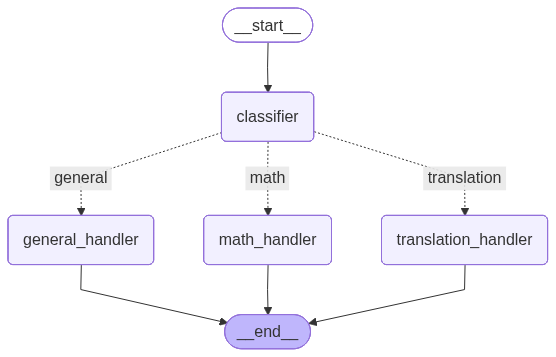

In [11]:
simple_app

In [12]:
# 테스트
test_questions = ["이 문장을 영어로 번역해주세요", "2 + 2는 얼마인가요?", "오늘 날씨가 어때요?"]

for question in test_questions:
    print(f"\n질문: {question}")
    result = simple_app.invoke({"question": question})
    print(f"분류: {result['question_type']}")
    print(f"답변: {result['answer']}")


질문: 이 문장을 영어로 번역해주세요
분류: translation
답변: 번역 전문 시스템이 '이 문장을 영어로 번역해주세요'을 처리했습니다.

질문: 2 + 2는 얼마인가요?
분류: general
답변: 일반 질의응답 시스템이 '2 + 2는 얼마인가요?'을 처리했습니다.

질문: 오늘 날씨가 어때요?
분류: general
답변: 일반 질의응답 시스템이 '오늘 날씨가 어때요?'을 처리했습니다.


### Router LLM

In [13]:
# Router LLM을 사용한 분류 시스템
from typing import Any, Dict

from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field


# Pydantic 모델 정의
class QuestionClassification(BaseModel):
    question_type: str = Field(description="질문 유형 (translation, math, general)")
    reasoning: str = Field(description="분류 이유")


# Router LLM 생성
def create_router_llm():
    """질문을 분석하고 적절한 핸들러를 선택하는 Router LLM"""
    return ChatOpenAI(
        model="gpt-4o-mini",
        temperature=0,
    )


router_llm = create_router_llm()
# Output Parser 설정
classification_parser = JsonOutputParser(pydantic_object=QuestionClassification)


# Router 체인 생성
router_chain = router_llm | classification_parser


# Router 분류 함수
def router_classify(state: SimpleState) -> Dict[str, Any]:
    """Router LLM이 질문을 분석하고 적절한 핸들러를 결정"""

    question = state.get("question", "")

    # JSON 출력을 위한 프롬프트
    classification_prompt = f"""다음 질문을 분석하여 가장 적절한 핸들러를 선택하세요:

질문: {question}

분류 기준:
- 번역 관련 질문 → translation
- 수학 계산 관련 질문 → math  
- 기타 일반적인 질문 → general

반드시 JSON 형식으로 응답하세요:
{{
    "question_type": "선택된_핸들러_타입",
    "reasoning": "분류 이유 설명"
}}"""

    try:
        parsed_output = router_chain.invoke([HumanMessage(content=classification_prompt)])
        question_type = parsed_output["question_type"]
        reasoning = parsed_output["reasoning"]

    except Exception as e:
        print(f"Router 오류: {e}")
        question_type = "general"  # 오류 시 기본값
        reasoning = "파싱 오류로 인한 기본 선택"

    return {
        "question_type": question_type,
        "reasoning": reasoning,
    }


# Router 다음 노드 결정 함수
def router_decide_next(state: SimpleState) -> str:
    """Router 분류 결과를 바탕으로 다음 노드 결정"""
    return state["question_type"]


# 개선된 워크플로우 생성
improved_workflow = StateGraph(SimpleState)

# 노드 추가
improved_workflow.add_node("router", router_classify)
improved_workflow.add_node("translation_handler", handle_translation)
improved_workflow.add_node("math_handler", handle_math)
improved_workflow.add_node("general_handler", handle_general)

# 엣지 연결
improved_workflow.add_edge(START, "router")

# Router LLM 기반 조건부 엣지 추가
improved_workflow.add_conditional_edges(
    "router",  # Router에서
    router_decide_next,  # Router 결정 함수
    {  # 반환값을 실제 노드에 매핑
        "translation": "translation_handler",
        "math": "math_handler",
        "general": "general_handler",
    },
)

# 모든 처리 노드에서 END로 연결
improved_workflow.add_edge("translation_handler", END)
improved_workflow.add_edge("math_handler", END)
improved_workflow.add_edge("general_handler", END)

# 개선된 그래프 컴파일
improved_app = improved_workflow.compile()

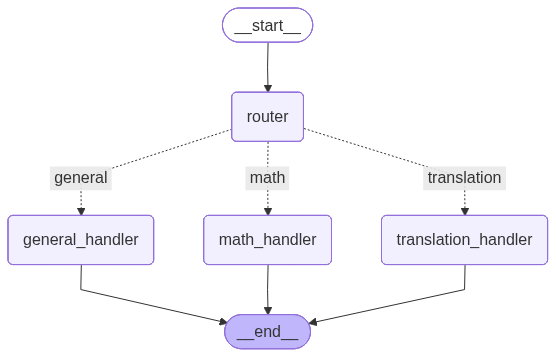

In [14]:
improved_app

In [15]:
# 테스트
test_questions = ["이 문장을 영어로 바꿔주세요", "1314 * 11 / 2 = ?", "오늘 나갈 때 우산을 들고 가야하나?"]

for question in test_questions:
    print(f"\n질문: {question}")
    result = improved_app.invoke({"question": question})
    print(f"분류: {result['question_type']}")
    print(f"답변: {result['answer']}")


질문: 이 문장을 영어로 바꿔주세요
분류: translation
답변: 번역 전문 시스템이 '이 문장을 영어로 바꿔주세요'을 처리했습니다.

질문: 1314 * 11 / 2 = ?
분류: math
답변: 수학 계산 시스템이 '1314 * 11 / 2 = ?'을 처리했습니다.

질문: 오늘 나갈 때 우산을 들고 가야하나?
분류: general
답변: 일반 질의응답 시스템이 '오늘 나갈 때 우산을 들고 가야하나?'을 처리했습니다.


## 7. LangGraph Multi-Agent 시스템

이제 기존의 단일 Agent를 개선하여 LangGraph를 사용한 Multi-Agent 시스템을 구축해보겠습니다.  
각각의 Agent는 특정 도구에 특화되어 병렬로 작업을 수행하며, Supervisor Agent가 전체적인 워크플로우를 조율합니다.

### 시스템 구조:
- **Supervisor Agent**: 사용자 질문을 분석하고 적절한 전문 Agent에게 작업을 분배
- **ML Agent**: 머신러닝 & 딥러닝 서적(Undestanding DL) 기반 질의
- **Web Search Agent**: 실시간 웹 검색 전담  
- **URL Analysis Agent**: 웹페이지 분석 및 요약 전담
- **Translation Agent**: 번역 작업 전담

In [16]:
import operator
import uuid
from typing import Annotated, Any, Dict, List, TypedDict

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

# 필요한 LangGraph 라이브러리 import
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import create_react_agent


# State 정의 - 각 Agent 간 정보 공유를 위한 상태
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str
    user_input: str
    selection_reasoning: str
    ml_result: str
    web_result: str
    url_result: str
    translation_result: str
    final_answer: str


# LLM 정의
llm_for_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [17]:
from langchain.chains.summarize import load_summarize_chain
from langchain.tools import tool
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_tavily import TavilySearch

# Tool 정의

# --- 도구 1: RAG 검색 도구 ---
retriever_tool = create_retriever_tool(
    retriever,
    "DeepLearningSearch",
    "머신러닝에 관련된 질문을 검색하고 반환합니다. 머신러닝이나 딥러닝에 관련된 질문에 사용해야 합니다. 최신 딥러닝 논문에 대한 내용은 포함되지 않을 수도 있습니다.",
)

# --- 도구 2: 웹 검색 도구 ---
tavily_tool = TavilySearch(
    k=5,
    description="최신 정보나 일반적인 사실에 대한 질문에 답하기 위해 웹을 검색합니다. 벡터 스토어에 없는 내용에 사용됩니다.",
)


# --- 도구 3: 웹페이지 분석/요약 도구 ---
@tool
def process_and_summarize_webpage(url: str):
    """
    사용자가 제공한 URL의 웹페이지 콘텐츠를 로드하여 분석하고 그 내용을 요약합니다.
    URL과 관련된 질문에 답하거나 내용을 요약해야 할 때 사용해야 합니다.
    """
    try:
        loader = WebBaseLoader([url])
        docs = loader.load()
        summarize_chain = load_summarize_chain(llm=llm_for_tools, chain_type="stuff")
        summary = summarize_chain.invoke(docs)  # run 대신 invoke 사용 (LangChain v0.2+)
        return summary
    except Exception as e:
        return f"오류가 발생했습니다: {e}"


# --- 도구 4: 번역 도구 ---
@tool
def translate_text(text: str, target_language: str):
    """
    주어진 텍스트를 지정된 대상 언어로 번역합니다.
    사용자가 번역을 요청할 때 사용해야 합니다.
    """
    prompt = ChatPromptTemplate.from_template("Translate the following text to {target_language}:\n\n{text}")
    translation_chain = prompt | llm_for_tools | StrOutputParser()
    return translation_chain.invoke({"text": text, "target_language": target_language})

In [18]:
# 4개의 전문화된 Agent 생성
from langchain_core.prompts import ChatPromptTemplate

# 각 Agent에 대한 시스템 프롬프트 정의
ml_system_prompt = """당신은 머신러닝 전문가입니다. 
머신러닝, 딥러닝, AI 관련 질문에 전문적으로 답변하세요.
관련 도구를 활용하여 정확한 정보를 제공하세요."""

web_system_prompt = """당신은 웹 검색 전문가입니다. 
최신 정보, 뉴스, 일반 상식에 대한 질문에 답변하세요.
검색 도구를 활용하여 최신 정보를 제공하세요."""

url_system_prompt = """당신은 웹페이지 분석 전문가입니다. 
URL이 포함된 질문에 대해 해당 웹페이지를 분석하고 요약하세요.
웹페이지 분석 도구를 활용하세요."""

translation_system_prompt = """당신은 번역 전문가입니다. 
다양한 언어 간 번역을 정확하고 자연스럽게 수행하세요.
번역 도구를 활용하여 고품질 번역을 제공하세요."""


# 1. 머신러닝 전문 Agent
ml_prompt = ChatPromptTemplate.from_messages([("system", ml_system_prompt), ("placeholder", "{messages}")])
ml_agent = create_react_agent(llm_for_tools, [retriever_tool], prompt=ml_prompt)  # ✅ RAG 검색 도구

# 2. Web Search Agent - 웹 검색 전문
web_prompt = ChatPromptTemplate.from_messages([("system", web_system_prompt), ("placeholder", "{messages}")])
web_search_agent = create_react_agent(llm_for_tools, [tavily_tool], prompt=web_prompt)  # ✅ Tavily 검색 도구

# 3. URL Analysis Agent - 웹페이지 분석 전문
url_prompt = ChatPromptTemplate.from_messages([("system", url_system_prompt), ("placeholder", "{messages}")])
url_analysis_agent = create_react_agent(
    llm_for_tools, [process_and_summarize_webpage], prompt=url_prompt  # ✅ URL 분석/요약 도구
)

# 4. Translation Agent - 번역 전문
translation_prompt = ChatPromptTemplate.from_messages(
    [("system", translation_system_prompt), ("placeholder", "{messages}")]
)
translation_agent = create_react_agent(llm_for_tools, [translate_text], prompt=translation_prompt)  # ✅ 번역 도구

### Supervisor
질문의 유형을 분석하고, 올바른 전문가에게 질문을 할당

In [19]:
# ============= Supervisor Agent =============

from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field


class AgentSelection(BaseModel):
    next_agent: str = Field(description="선택된 다음 에이전트 이름")
    reasoning: str = Field(description="선택 이유")


def create_supervisor_agent():
    """질문을 분석하고 적절한 전문 Agent를 선택하는 Supervisor"""
    return ChatOpenAI(
        model="gpt-4o-mini",
        temperature=0,
        model_kwargs={"response_format": {"type": "json_object"}},  # ✅ JSON 형식 보장
    )


supervisor_llm = create_supervisor_agent()
parser = JsonOutputParser(pydantic_object=AgentSelection)  # ✅ Supervisor 출력 파서

# Supervisor 체인 생성
supervisor_chain = supervisor_llm | parser


def supervisor_node(state: AgentState) -> Dict[str, Any]:
    """Supervisor가 질문을 분석하고 다음 Agent를 결정"""

    user_input = state.get("user_input", "")

    # JSON 출력을 위한 프롬프트
    analysis_prompt = f"""다음 질문을 분석하여 가장 적절한 Agent를 선택하세요:

질문: {user_input}

선택 기준:
- 머신러닝 또는 딥러닝에 관련된 질문 → ml_agent
- 최신 정보, 일반 상식, 현재 동향 → web_search_agent  
- URL이 포함됨 → url_analysis_agent
- 번역 요청 → translation_agent

반드시 JSON 형식으로 응답하세요:
{{
    "agent": "선택된_에이전트_이름",
    "reasoning": "선택 이유 설명"
}}"""

    try:
        parsed_output = supervisor_chain.invoke([HumanMessage(content=analysis_prompt)])
        next_agent = parsed_output["agent"]  # ✅ JSON 결과에서 추출
        reasoning = parsed_output["reasoning"]

    except Exception as e:
        print(f"Supervisor 오류: {e}")
        next_agent = "web_search_agent"  # 오류 시 기본값
        reasoning = "파싱 오류로 인한 기본 선택"

    return {
        "next": next_agent,  # ✅ 다음 노드
        "selection_reasoning": reasoning,  # ✅ 선택 이유 저장
    }

### 각 에이전트 노드

In [20]:
def ml_agent_node(state: AgentState) -> Dict[str, Any]:
    """ML Agent 노드 - 머신러닝 관련 질문 처리"""
    user_input = state.get("user_input", "")

    try:
        result = ml_agent.invoke({"messages": [HumanMessage(content=user_input)]})
        answer = result["messages"][-1].content if result.get("messages") else "답변 생성 실패"

        return {"rag_result": answer, "final_answer": answer, "messages": [AIMessage(content=answer)]}
    except Exception as e:
        error_msg = f"ML Agent 처리 오류: {str(e)}"
        return {"rag_result": error_msg, "final_answer": error_msg, "messages": [AIMessage(content=error_msg)]}


def web_search_agent_node(state: AgentState) -> Dict[str, Any]:
    """Web Search Agent 노드 - 웹 검색 처리"""
    user_input = state.get("user_input", "")

    try:
        result = web_search_agent.invoke({"messages": [HumanMessage(content=user_input)]})
        answer = result["messages"][-1].content if result.get("messages") else "답변 생성 실패"

        return {"web_result": answer, "final_answer": answer, "messages": [AIMessage(content=answer)]}
    except Exception as e:
        error_msg = f"Web Search Agent 처리 오류: {str(e)}"
        return {"web_result": error_msg, "final_answer": error_msg, "messages": [AIMessage(content=error_msg)]}


def url_analysis_agent_node(state: AgentState) -> Dict[str, Any]:
    """URL Analysis Agent 노드 - URL 분석 처리"""
    user_input = state.get("user_input", "")

    try:
        result = url_analysis_agent.invoke({"messages": [HumanMessage(content=user_input)]})
        answer = result["messages"][-1].content if result.get("messages") else "답변 생성 실패"

        return {"url_result": answer, "final_answer": answer, "messages": [AIMessage(content=answer)]}
    except Exception as e:
        error_msg = f"URL Analysis Agent 처리 오류: {str(e)}"
        return {"url_result": error_msg, "final_answer": error_msg, "messages": [AIMessage(content=error_msg)]}


def translation_agent_node(state: AgentState) -> Dict[str, Any]:
    """Translation Agent 노드 - 번역 처리"""
    user_input = state.get("user_input", "")

    try:
        result = translation_agent.invoke({"messages": [HumanMessage(content=user_input)]})
        answer = result["messages"][-1].content if result.get("messages") else "답변 생성 실패"

        return {"translation_result": answer, "final_answer": answer, "messages": [AIMessage(content=answer)]}
    except Exception as e:
        error_msg = f"Translation Agent 처리 오류: {str(e)}"
        return {"translation_result": error_msg, "final_answer": error_msg, "messages": [AIMessage(content=error_msg)]}

### Workflow 구성

In [21]:
def create_multi_agent_graph():
    """멀티 에이전트 워크플로우 생성"""
    workflow = StateGraph(AgentState)

    # 노드 추가
    workflow.add_node("supervisor", supervisor_node)
    workflow.add_node("ml_agent", ml_agent_node)
    workflow.add_node("web_search_agent", web_search_agent_node)
    workflow.add_node("url_analysis_agent", url_analysis_agent_node)
    workflow.add_node("translation_agent", translation_agent_node)

    # 라우터 함수
    def supervisor_router(state: AgentState) -> str:
        """Supervisor의 결정에 따라 다음 노드 결정"""
        return state.get("next", "web_search_agent")  # 기본값 설정

    # 엣지 설정
    workflow.add_edge(START, "supervisor")

    # 조건부 엣지 - supervisor에서 각 agent로
    workflow.add_conditional_edges(
        source="supervisor",
        path=supervisor_router,  # ✅ supervisor_router 함수 사용
        path_map={  # ✅ Supervisor 결과 → 실제 노드 매핑
            "ml_agent": "ml_agent",
            "web_search_agent": "web_search_agent",
            "url_analysis_agent": "url_analysis_agent",
            "translation_agent": "translation_agent",
        },
    )

    # 각 agent에서 END로
    workflow.add_edge("ml_agent", END)
    workflow.add_edge("web_search_agent", END)
    workflow.add_edge("url_analysis_agent", END)
    workflow.add_edge("translation_agent", END)

    # 메모리 체크포인터 추가
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)
    return app

In [22]:
# 워크플로우 생성
multi_agent_system = create_multi_agent_graph()

✨ 복잡한 `LangGraph` 그래프를 주피터 노트북에 표시할 때, **`mermaid.ink` API의 시간 초과** 오류를 피하기 위해 **로컬 렌더링 방식**을 사용했습니다.

* `LangGraph.compile()` 메서드는 `draw_method` 인자를 직접 받지 않습니다.
* **그래프 시각화 오류**: 노드가 많아 복잡해진 그래프는 외부 API(mermaid.ink) 호출 시 **TimeoutError**를 발생시킵니다.
* **해결 방법**: `compile()` 이후 `get_graph().draw_mermaid_png()` 메서드에 **`draw_method=MermaidDrawMethod.PYPPETEER`** 인자를 전달하여 로컬에서 렌더링했습니다.
* **결과**: 이 방식은 네트워크 의존성을 제거하여 **안정성**과 **보안**을 높이고, 복잡한 그래프도 **성능 저하 없이** 시각화할 수 있습니다.
* **최종 코드**: `app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)`


In [44]:
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

graph_png = multi_agent_system.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
# 그래프 이미지를 파일로 저장합니다.
try:
    graph_png = multi_agent_system.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
    with open("my_agent_workflow.png", "wb") as f:
        f.write(graph_png)
    print("그래프가 'my_agent_workflow.png' 파일로 성공적으로 저장되었습니다.")
except Exception as e:
    print(f"그래프 저장 중 오류 발생: {e}")

그래프가 'my_agent_workflow.png' 파일로 성공적으로 저장되었습니다.


또는 [Mermaid Live](https://mermaid.live/edit) site에 접속하여 아래 코드의 실행결과를 복/붙하여 그래프를 생성하는 방법이 있습니다.

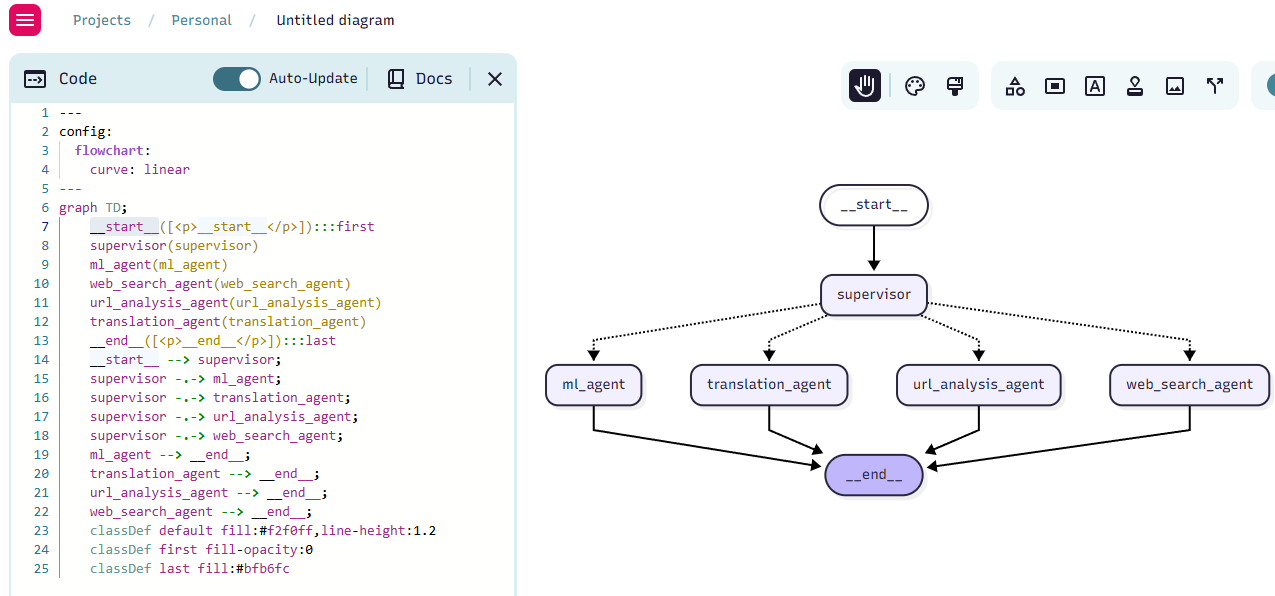


In [23]:
# 셀에서 실행
print(multi_agent_system.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	supervisor(supervisor)
	ml_agent(ml_agent)
	web_search_agent(web_search_agent)
	url_analysis_agent(url_analysis_agent)
	translation_agent(translation_agent)
	__end__([<p>__end__</p>]):::last
	__start__ --> supervisor;
	supervisor -.-> ml_agent;
	supervisor -.-> translation_agent;
	supervisor -.-> url_analysis_agent;
	supervisor -.-> web_search_agent;
	ml_agent --> __end__;
	translation_agent --> __end__;
	url_analysis_agent --> __end__;
	web_search_agent --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [41]:
# 실행 함수


def run_multi_agent_system(question: str, config: dict = None):
    """멀티 에이전트 시스템 실행"""

    # 각 실행마다 고유한 thread_id 생성
    if config is None:
        config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    # 초기 상태 설정
    initial_state = {
        "messages": [],
        "next": "",
        "user_input": question,
        "selection_reasoning": "",
        "ml_result": "",
        "web_result": "",
        "url_result": "",
        "translation_result": "",
        "final_answer": "",
    }

    print(f"\n{'='*50}")
    print(f"질문: {question}")
    print(f"{'='*50}")

    try:
        # 워크플로우 실행
        result = multi_agent_system.invoke(initial_state, config)

        # final_answer가 설정되어 있으면 우선 사용
        final_answer = result.get("final_answer") or (
            result.get("rag_result")
            or result.get("web_result")
            or result.get("url_result")
            or result.get("translation_result")
            or "답변을 생성할 수 없습니다."
        )

        print(f"\n답변: {final_answer}")
        print(f"{'='*50}\n")

        return {
            **result,
            "final_answer": final_answer,
            "next": result.get("next"),
            "selection_reasoning": result.get("selection_reasoning"),
        }

    except Exception as e:
        error_msg = f"시스템 오류: {str(e)}"
        print(f"\n오류: {error_msg}")
        print(f"{'='*50}\n")

        return {"error": error_msg, "final_answer": error_msg}

In [42]:
test_questions = [
    "GPT와 BERT의 차이점을 비교 분석해줘",
    "2025년 현재 한국의 기준금리는 얼마인가요?",
    "https://openai.com/blog/chatgpt 이 페이지의 핵심 내용을 한국어로 요약해줘",
    "다음 텍스트를 자연스러운 영어로 번역해줘: '인공지능 기술의 발전으로 우리의 일상생활이 크게 변화하고 있습니다.'",
    "Python으로 간단한 신경망을 구현하는 방법을 알려줘",
    "오늘 서울 날씨와 미세먼지 농도는 어떤가요?",
    "머신러닝에서 과적합을 방지하는 효과적인 방법들을 설명해줘",
    "최근 Huggingface 업데이트 소식이 있나요?",
]

In [43]:
for q in test_questions:
    result = run_multi_agent_system(q)
    print(f"라우팅 결과: {result['next']}")
    print(f"선택 이유: {result['selection_reasoning']}")
    print("=" * 80)


질문: GPT와 BERT의 차이점을 비교 분석해줘

답변: GPT (Generative Pre-trained Transformer)와 BERT (Bidirectional Encoder Representations from Transformers)는 둘 다 Transformer 아키텍처를 기반으로 한 자연어 처리(NLP) 모델이지만, 그 구조와 목적에서 몇 가지 중요한 차이점이 있습니다.

### 1. 아키텍처
- **GPT**: GPT는 주로 디코더 구조를 사용합니다. 이는 다음 단어를 예측하는 오토리그레시브(autoregressive) 모델로, 입력 시퀀스의 왼쪽 컨텍스트만을 사용하여 다음 단어를 생성합니다. 즉, 각 단어는 이전 단어들만을 참조하여 예측됩니다.
  
- **BERT**: BERT는 인코더 구조를 사용하며, 양방향으로 문맥을 이해할 수 있습니다. 이는 입력 시퀀스의 모든 단어가 서로를 참조할 수 있도록 하여, 문맥을 더 잘 이해할 수 있게 합니다. BERT는 마스킹된 언어 모델링(Masked Language Modeling) 방식을 사용하여, 일부 단어를 마스킹하고 그 단어를 예측하는 방식으로 학습합니다.

### 2. 학습 방식
- **GPT**: GPT는 주로 다음 단어 예측을 통해 학습합니다. 이는 주어진 텍스트의 다음 단어를 예측하는 방식으로, 대량의 텍스트 데이터를 사용하여 사전 학습됩니다. 이후 특정 작업에 맞게 파인튜닝할 수 있습니다.

- **BERT**: BERT는 두 가지 주요 작업을 통해 학습합니다: 마스킹된 언어 모델링과 다음 문장 예측(Next Sentence Prediction). 이로 인해 BERT는 문맥을 더 잘 이해하고, 다양한 NLP 작업에 대해 더 나은 성능을 발휘할 수 있습니다.

### 3. 사용 사례
- **GPT**: 주로 텍스트 생성, 대화형 AI, 스토리 작성 등에서 사용됩니다. GPT는 주어진 프롬프트에 따라 자연스럽고 일관된 텍스트를 생성하는 데 강점을 보입니다.

- **BERT**: 주로 